In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
from tqdm import tqdm

In [268]:
# астрономические параметры

mu = 1.3272e11

r1 = 150e6
r2 = 225e6

x1 = r1*math.cos(10*math.pi/180)
y1 = r1*math.sin(10*math.pi/180)

x2 = r2*math.cos(200*math.pi/180)
y2 = r2*math.sin(200*math.pi/180)

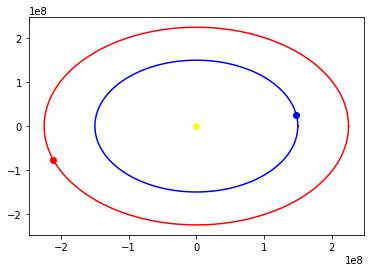

In [269]:
# рисуем орбиты, планеты и Солнце

planet_1_x = list()
planet_1_y = list()
for i in range(0, 361):
    x_dot = r1 * np.cos(i*math.pi/180)
    y_dot = r1 * np.sin(i*math.pi/180)
    planet_1_x.append(x_dot)
    planet_1_y.append(y_dot)
    

planet_2_x = list()
planet_2_y = list()
for i in range(0, 361):
    x_dot = r2 * np.cos(i*math.pi/180)
    y_dot = r2 * np.sin(i*math.pi/180)
    planet_2_x.append(x_dot)
    planet_2_y.append(y_dot)
    
    
plt.plot(planet_2_x, planet_2_y, color = 'red')
plt.plot(planet_1_x, planet_1_y, color = 'blue')
plt.scatter(x1, y1, color = 'blue')
plt.scatter(x2, y2, color = 'red')
plt.scatter(0, 0, color = 'yellow')

In [270]:
# зададим радиус-векторы

r_1 = np.array([x1, y1])
r_2 = np.array([x2, y2])
D = r_2 - r_1

In [271]:
# определим угловые величины

cos_fi = np.dot(r_1, r_2) / (np.linalg.norm(r_2) * np.linalg.norm(r_1))
sin_fi = np.linalg.norm(np.cross(r_1, r_2)) / (np.linalg.norm(r_2) * np.linalg.norm(r_1))
v_p = np.cross(r_1, r_2)
v_sign = math.copysign(1, v_p)
sin_fi = sin_fi * v_sign

if math.copysign(1, sin_fi) >= 0:
    fi = math.acos(cos_fi)
if math.copysign(1, sin_fi) < 0:
    fi = 2*math.pi - math.acos(cos_fi)

In [272]:
# Проверка 1. выведите угловую дальность в градусах и сравните её визуально
# с картинкой наверху

fi*180 / math.pi

190.0

In [273]:
# задаём начальное приближение для решения уравнения Ламберта

a_min = (np.linalg.norm(r_1) + np.linalg.norm(r_2) + np.linalg.norm(D)) / 4
delta_min = math.acos(1-(np.linalg.norm(r_1) + np.linalg.norm(r_2) - np.linalg.norm(D))/(2*a_min))

t_pz = a_min**(1.5)*(math.pi - math.copysign(1, sin_fi)*(delta_min - math.sin(delta_min)))/np.sqrt(mu)

In [274]:
# выводим t_pz в первом приближении

t_pz/(24*60*60)

255.56030714907425

In [275]:
# ищем, сколько времени заняла фактическая миссия в днях, например 280

t_p = 280 *24*60*60

In [276]:
# теперь нужно организовать цикл таким образом, чтобы наша расчётная t_pz
# оказалась равна фактической. Необходимо добавлять некоторую величину к a_min

while t_pz < t_p:
    a_min = a_min + 100
    eps_v = math.acos(1-((np.linalg.norm(r_1) + np.linalg.norm(r_2) + np.linalg.norm(D))/(2*a_min)))
    delta_v = math.acos(1-((np.linalg.norm(r_1) + np.linalg.norm(r_2) - np.linalg.norm(D))/(2*a_min)))

    if t_p < t_pz:
        eps = eps_v
    if t_p > t_pz:
        eps = 2*math.pi - eps_v
    if t_p == t_pz:
        eps = math.pi

    if fi < math.pi:
        delta = delta_v
    if fi > math.pi:
        delta = - delta_v
    if fi == math.pi:
        delta = 0
    t_pz = (a_min**1.5)*(eps - delta - (math.sin(eps) - math.sin(delta)))/np.sqrt(mu)

In [277]:
# снова смотрим на t_pz, должно быть примерно как t_p, погрешность на 4 знаке

t_pz/(24*60*60)

280.00076645554753

In [278]:
# теперь определим параметры орбиты перехода

p = np.linalg.norm(r_1) * np.linalg.norm(r_2) * ((math.sin(fi/2))**2) /(a_min * (math.sin((eps - delta)/2))**2)
ex = np.sqrt(1 - p / a_min)

cos_teta_1 = (p - np.linalg.norm(r_1)) / (ex * np.linalg.norm(r_1))
cos_teta_2 = (p - np.linalg.norm(r_2)) / (ex * np.linalg.norm(r_2))
sin_teta_1 = (math.cos(fi) * cos_teta_1 - cos_teta_2) / math.sin(fi)

if math.copysign(1, sin_teta_1) >= 0:
    teta_1 = math.acos(cos_teta_1)
if math.copysign(1, sin_teta_1) < 0:
    teta_1 = 2 * math.pi - math.acos(cos_teta_1)
    
teta_2 = teta_1 + fi

lambda0 = math.acos(x1*(1+ex*math.cos(teta_1))/p) - teta_1
lambda02 = math.asin(y1*(1+ex*math.cos(teta_1))/p) - teta_1

In [279]:
# Проверка 2. Должны получить радиусы начальной и конечной орбиты

print (p / (1 + ex * math.cos(teta_1)))
print (p / (1 + ex * math.cos(teta_2)))

150000000.0
225000000.0


In [280]:
# Теперь определяем саму траекторию

Lambert_transfer_x = list()
Lambert_transfer_y = list()

for i in range(int(teta_1 * 180 / 3.1416), int(teta_2 * 180 / 3.1416)+1):
    teta_i = i*math.pi / 180
    rg_i = p / (1 + ex * math.cos(teta_i))
    Lambert_x = rg_i * math.cos(teta_i + lambda0)
    Lambert_y = rg_i * math.sin(teta_i + lambda0)
    Lambert_transfer_x.append(Lambert_x)
    Lambert_transfer_y.append(Lambert_y)

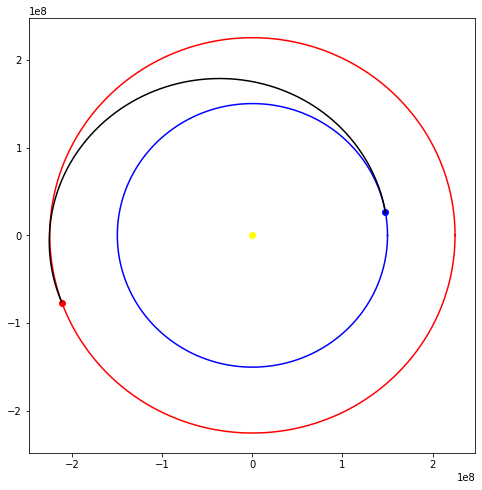

In [281]:
plt.figure(figsize=(8, 8))
plt.plot(planet_2_x, planet_2_y, color = 'red')
plt.plot(planet_1_x, planet_1_y, color = 'blue')
plt.plot(Lambert_transfer_x, Lambert_transfer_y, color = 'black')
plt.scatter(x1, y1, color = 'blue')
plt.scatter(x2, y2, color = 'red')
plt.scatter(0, 0, color = 'yellow')

In [286]:
# Считаем первый импульс

v_r_1 = np.sqrt(mu/p)*ex*math.sin(teta_1)
v_f_1 = np.sqrt(mu/p)*(1 + ex*math.cos(teta_1))
v_f_start = np.sqrt(mu/np.linalg.norm(r_1))

impulse_1 = np.sqrt(v_r_1**2 + (v_f_1 - v_f_start)**2)

In [288]:
# Считаем второй импульс

v_r_2 = np.sqrt(mu/p)*ex*math.sin(teta_2)
v_f_2 = np.sqrt(mu/p)*(1 + ex*math.cos(teta_2))
v_f_finish = np.sqrt(mu/np.linalg.norm(r_2))

impulse_2 = np.sqrt(v_r_2**2 + (v_f_2 - v_f_finish)**2)

In [290]:
# Считаем суммарный импульс

impulse_sum = impulse_1 + impulse_2